In [1]:
import pandas as pd
import os

data_name = 'TenneseeEastman'
data = pd.read_csv(f'{data_name}/data.csv', index_col=0)
data.to_csv(f'data_{data_name}/0_data.csv', index=False, header=False)

def adjacency_to_parents_dict(filename):
    parents_dict = {}
    with open(filename, 'r') as f:
        lines = f.readlines()
        for child_index, line in enumerate(lines):
            values = list(map(int, line.strip().split('\t')))
            parents_dict[child_index] = [(child_index,-1)]
            for parent_index, value in enumerate(values):
                if value == 1:
                    parents_dict[child_index].append((parent_index,-1))
    return parents_dict

parents = adjacency_to_parents_dict(f'{data_name}/GroundTruth.txt')
with open(f'data_{data_name}/0_node_parents.txt', 'w') as f:
    f.write(str(parents))

In [2]:
from group_causation.groups_extraction import GeneticCausalGroupsExtractor


def extract_and_save_groups(data_name):
    data = pd.read_csv(f'./data_{data_name}/0_data.csv', header=None).values
    group_extractor = GeneticCausalGroupsExtractor(data, 
                                                scores=['explainability_score'], 
                                                scores_weights=[1.0])
        
    groups = group_extractor.extract_groups()

    print(data_name, 'dataset obtained the groups:', groups)
    
    with open(f'./data_{data_name}/0_groups.txt', 'w') as f:
        f.write(str(groups))
    

# extract_and_save_groups(data_name)

## Convert node-level parents to group-level parents

In [3]:
def find_index_with_element(groups, x):
    for i, group in enumerate(groups):
        if x in group: return i
    return None

with open(f'./data_{data_name}/0_groups.txt', 'r') as f:
    groups = eval(f.read())
with open(f'./data_{data_name}/0_node_parents.txt', 'r') as f:
    node_parents = eval(f.read())

group_parents = {}
for son_group_idx, son_group in enumerate(groups):
    group_parents[son_group_idx] = []
    for son_node in son_group:
        for parent_node, lag in node_parents[son_node]:
            parent_group_idx = find_index_with_element(groups, parent_node)
            if parent_group_idx is None:
                print(f'Error: parent node {parent_node} not found in any group')
                continue
            if (parent_group_idx, lag) not in group_parents[son_group_idx]:
                group_parents[son_group_idx].append((parent_group_idx, -1))
            
with open(f'./data_{data_name}/0_parents.txt', 'w') as f:
    f.write(str(group_parents))

## Perform the Benchmark

In [4]:
from matplotlib import pyplot as plt

from group_causation.benchmark import BenchmarkGroupCausalDiscovery

from group_causation.utils import static_parameters
from group_causation.group_causal_discovery import DimensionReductionGroupCausalDiscovery
from group_causation.group_causal_discovery import MicroLevelGroupCausalDiscovery
from group_causation.group_causal_discovery import HybridGroupCausalDiscovery

algorithms = {
    'group-embedding': HybridGroupCausalDiscovery,
    'subgroups': HybridGroupCausalDiscovery,
    'pca+pcmci': DimensionReductionGroupCausalDiscovery,
    # 'pca+dynotears': DimensionReductionGroupCausalDiscovery,
    'micro-level': MicroLevelGroupCausalDiscovery,
}
algorithms_parameters = {
    'pca+pcmci': {'dimensionality_reduction': 'pca', 'node_causal_discovery_alg': 'pcmci',
                            'node_causal_discovery_params': {'min_lag': 1, 'max_lag': 3, 'pc_alpha': 0.05}},
    
    'pca+dynotears': {'dimensionality_reduction': 'pca', 'node_causal_discovery_alg': 'dynotears',
                            'node_causal_discovery_params': {'min_lag': 1, 'max_lag': 3, 'lambda_w': 0.0000000, 'lambda_a': 0.0000000}},
    
    'micro-level': {'node_causal_discovery_alg': 'pcmci',
                            'node_causal_discovery_params': {'min_lag': 1, 'max_lag': 3, 'pc_alpha': 0.05}},
    
    'group-embedding': {'dimensionality_reduction': 'pca', 
               'dimensionality_reduction_params': {'explained_variance_threshold': 0.5,
                                                   'groups_division_method': 'group_embedding'},
                'node_causal_discovery_alg': 'pcmci',
                'node_causal_discovery_params': {'min_lag': 1, 'max_lag': 3, 'pc_alpha': 0.05},
                'verbose': 0},
    
    'subgroups': {'dimensionality_reduction': 'pca', 
               'dimensionality_reduction_params': {'explained_variance_threshold': 0.5,
                                                   'groups_division_method': 'subgroups'},
                'node_causal_discovery_alg': 'pcmci',
                'node_causal_discovery_params': {'min_lag': 1, 'max_lag': 3, 'pc_alpha': 0.05},
                'verbose': 0},
}

data_generation_options = {}

benchmark_options = {
    'static_parameters': (static_parameters, {}),
}

chosen_option = 'static_parameters'


def execute_benchmark(data_name):
    benchmark = BenchmarkGroupCausalDiscovery()
    results_folder = f'results_{data_name}'
    datasets_folder = f'data_{data_name}'
    
    options_generator, options_kwargs = benchmark_options[chosen_option]
    parameters_iterator = options_generator(data_generation_options,
                                                algorithms_parameters,
                                                **options_kwargs)
    results = benchmark.benchmark_causal_discovery(algorithms=algorithms,
                                        parameters_iterator=parameters_iterator,
                                        datasets_folder=datasets_folder,
                                        generate_toy_data=False,
                                        results_folder=results_folder,
                                        n_executions=1,
                                        verbose=2)
    
    return results, benchmark

In [5]:
execute_benchmark(data_name)


--------------------------------------------------
 Datasets have been loaded. 
 Executing algorithm group-embedding 


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:10<00:00, 10.91s/it]


Algorithm HybridGroupCausalDiscovery executed in 10.872 seconds and 297.320 MB of memory
Predicted parents: {0: [(4, -1), (3, -1), (0, -1), (4, -2)], 1: [(2, -1), (3, -2), (3, -1), (4, -3), (2, -3), (1, -2), (1, -1), (1, -3)], 2: [(2, -2), (2, -1), (3, -1), (3, -2), (4, -3), (2, -3), (4, -2)], 3: [(2, -1), (2, -2), (3, -1), (3, -2), (2, -3), (3, -3), (1, -1), (4, -1), (0, -1)], 4: [(3, -1), (3, -2), (4, -3), (1, -1), (1, -3), (4, -2), (4, -1), (0, -1)]}
Predicted parents summary: {0: [(4, -1), (3, -1), (0, -1)], 1: [(4, -1), (2, -1), (3, -1), (1, -1)], 2: [(4, -1), (2, -1), (3, -1)], 3: [(2, -1), (3, -1), (1, -1), (4, -1), (0, -1)], 4: [(4, -1), (3, -1), (1, -1), (0, -1)]}
results_per_execution=[{'time': 10.872054815292358, 'memory': 297.320448, 'TP': 13, 'FP': 23, 'FN': 3, 'precision': 0.3611111111111111, 'recall': 0.8125, 'f1': 0.5, 'shd': 26, 'TP_summary': 15, 'FP_summary': 4, 'FN_summary': 1, 'precision_summary': 0.7894736842105263, 'recall_summary': 0.9375, 'f1_summary': 0.8571428

100%|██████████| 1/1 [00:17<00:00, 17.31s/it]


Algorithm HybridGroupCausalDiscovery executed in 17.198 seconds and 298.095 MB of memory
Predicted parents: {0: [(3, -2), (3, -1), (1, -1), (4, -2), (4, -1), (0, -2)], 1: [(2, -1), (3, -2), (3, -1), (4, -3), (1, -2), (1, -1), (1, -3), (4, -1), (0, -2)], 2: [(2, -2), (2, -1), (3, -1), (3, -2), (2, -3), (3, -3), (1, -1)], 3: [(2, -1), (2, -2), (3, -1), (3, -2), (2, -3), (3, -3), (1, -1), (1, -2), (1, -3), (4, -1)], 4: [(2, -2), (2, -1), (3, -1), (3, -2), (4, -3), (1, -1), (4, -2), (4, -1)]}
Predicted parents summary: {0: [(4, -1), (3, -1), (1, -1), (0, -1)], 1: [(2, -1), (3, -1), (1, -1), (4, -1), (0, -1)], 2: [(2, -1), (3, -1), (1, -1)], 3: [(4, -1), (2, -1), (3, -1), (1, -1)], 4: [(4, -1), (2, -1), (3, -1), (1, -1)]}
results_per_execution=[{'time': 17.19824981689453, 'memory': 298.094592, 'TP': 13, 'FP': 27, 'FN': 3, 'precision': 0.325, 'recall': 0.8125, 'f1': 0.46428571428571436, 'shd': 30, 'TP_summary': 14, 'FP_summary': 6, 'FN_summary': 2, 'precision_summary': 0.7, 'recall_summary':

100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


Algorithm DimensionReductionGroupCausalDiscovery executed in 2.345 seconds and 298.484 MB of memory
Predicted parents: {0: [(4, -1), (4, -2), (2, -1)], 1: [(1, -1), (2, -1), (1, -2), (2, -3)], 2: [(2, -3), (2, -1), (2, -2)], 3: [(3, -1), (2, -1), (3, -2), (4, -1), (1, -2)], 4: [(4, -1), (4, -2), (4, -3), (3, -1)]}
Predicted parents summary: {0: [(4, -1), (2, -1)], 1: [(2, -1), (1, -1)], 2: [(2, -1)], 3: [(4, -1), (2, -1), (3, -1), (1, -1)], 4: [(4, -1), (3, -1)]}
results_per_execution=[{'time': 2.344937562942505, 'memory': 298.48371199999997, 'TP': 6, 'FP': 13, 'FN': 10, 'precision': 0.3157894736842105, 'recall': 0.375, 'f1': 0.34285714285714286, 'shd': 23, 'TP_summary': 7, 'FP_summary': 4, 'FN_summary': 9, 'precision_summary': 0.6363636363636364, 'recall_summary': 0.4375, 'f1_summary': 0.5185185185185185, 'shd_summary': 13}]
 Executing algorithm micro-level 


100%|██████████| 1/1 [00:41<00:00, 41.85s/it]

Algorithm MicroLevelGroupCausalDiscovery executed in 41.838 seconds and 304.652 MB of memory
Predicted parents: {0: [(2, -2), (3, -1), (3, -2), (3, -3), (4, -2), (4, -1), (0, -2)], 1: [(2, -1), (3, -2), (3, -1), (4, -3), (3, -3), (1, -1), (1, -2), (4, -2), (4, -1), (0, -2)], 2: [(2, -1), (2, -2), (0, -3), (3, -1), (3, -2), (2, -3), (3, -3), (1, -1), (4, -1), (4, -2), (0, -1)], 3: [(2, -1), (2, -2), (0, -3), (3, -2), (3, -1), (4, -3), (3, -3), (1, -1), (4, -2), (4, -1), (0, -2)], 4: [(2, -1), (3, -1), (3, -2), (4, -3), (3, -3), (4, -2), (4, -1), (0, -1)]}
Predicted parents summary: {0: [(4, -1), (2, -1), (3, -1), (0, -1)], 1: [(2, -1), (3, -1), (1, -1), (4, -1), (0, -1)], 2: [(2, -1), (3, -1), (1, -1), (4, -1), (0, -1)], 3: [(2, -1), (3, -1), (1, -1), (4, -1), (0, -1)], 4: [(4, -1), (2, -1), (3, -1), (0, -1)]}
results_per_execution=[{'time': 41.83779716491699, 'memory': 304.652288, 'TP': 12, 'FP': 35, 'FN': 4, 'precision': 0.2553191489361702, 'recall': 0.75, 'f1': 0.380952380952381, 'sh

({'group-embedding': [{'time': 10.872054815292358,
    'memory': 297.320448,
    'TP': 13,
    'FP': 23,
    'FN': 3,
    'precision': 0.3611111111111111,
    'recall': 0.8125,
    'f1': 0.5,
    'shd': 26,
    'TP_summary': 15,
    'FP_summary': 4,
    'FN_summary': 1,
    'precision_summary': 0.7894736842105263,
    'recall_summary': 0.9375,
    'f1_summary': 0.8571428571428572,
    'shd_summary': 5,
    'dataset_iteration': 0}],
  'subgroups': [{'time': 17.19824981689453,
    'memory': 298.094592,
    'TP': 13,
    'FP': 27,
    'FN': 3,
    'precision': 0.325,
    'recall': 0.8125,
    'f1': 0.46428571428571436,
    'shd': 30,
    'TP_summary': 14,
    'FP_summary': 6,
    'FN_summary': 2,
    'precision_summary': 0.7,
    'recall_summary': 0.875,
    'f1_summary': 0.7777777777777777,
    'shd_summary': 8,
    'dataset_iteration': 0}],
  'pca+pcmci': [{'time': 2.344937562942505,
    'memory': 298.48371199999997,
    'TP': 6,
    'FP': 13,
    'FN': 10,
    'precision': 0.3157894736

In [6]:
results = [pd.read_csv(f'results_{data_name}/{file}') for file in os.listdir(f'results_{data_name}') if file.endswith('.csv')]
algorithms = [file.split('_')[1].split('.')[0] for file in os.listdir(f'results_{data_name}') if file.endswith('.csv')]

for result, algorithm in zip(results, algorithms): result['algorithm'] = algorithm
results = pd.concat(results, ignore_index=True)

results = results[['algorithm', 'precision_summary', 'recall_summary', 'f1_summary', 'shd_summary', 'time']]
# results
print(results.to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrr}
\toprule
 & algorithm & precision_summary & recall_summary & f1_summary & shd_summary & time \\
\midrule
0 & micro-level & 0.609 & 0.875 & 0.718 & 11 & 41.838 \\
1 & subgroups & 0.700 & 0.875 & 0.778 & 8 & 17.198 \\
2 & group-embedding & 0.789 & 0.938 & 0.857 & 5 & 10.872 \\
3 & pca+pcmci & 0.636 & 0.438 & 0.519 & 13 & 2.345 \\
4 & pca+dynotears & 0.000 & 0.000 & 0.000 & 31 & 165.253 \\
\bottomrule
\end{tabular}



{0: [(0, -1), (4, -1), (3, -1), (1, -1)], 1: [(1, -1), (4, -1), (3, -1)], 2: [(2, -1), (3, -1), (4, -1)], 3: [(3, -1), (2, -1), (0, -1), (1, -1)], 4: [(4, -1), (1, -1)]}


<Figure size 1000x600 with 0 Axes>

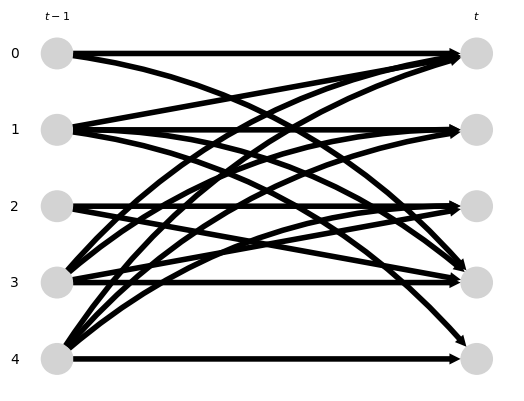

In [7]:
from group_causation.create_toy_datasets import plot_ts_graph

def plot_parents_graph(data_name):
    with open(f'data_{data_name}/0_parents.txt') as f:
        group_parents = eval(f.read())
        
    print(group_parents)
    plt.figure(figsize=(10, 6))
    plot_ts_graph(group_parents)
    plt.savefig(f'results_{data_name}/parents_graph.pdf')

plot_parents_graph(data_name)

In [23]:
def show_false_positives_and_negatives(predicted_parents):
    with open(f'data_{data_name}/0_parents.txt') as f:
        real_parents = eval(f.read())
    
    false_positives = '\{'
    false_negatives = '\{'
    for group_idx, parents in predicted_parents.items():
        for parent_idx, lag in parents:
            if (parent_idx, -1) not in real_parents[group_idx]:
                false_positives += f'$X^{parent_idx}'+'_{t-1}\\rightarrow X^'+f'{group_idx}_t$, '
        for real_parent_idx, real_lag in real_parents[group_idx]:
            if (real_parent_idx, real_lag) not in parents:
                false_negatives += f'$X^{real_parent_idx}'+'_{t-1}\\rightarrow X^'+f'{group_idx}_t$, '

    false_positives = false_positives[:-2] + '\}'
    false_negatives = false_negatives[:-2] + '\}'
    print(f'False positives: {false_positives}')
    print(f'False negatives: {false_negatives}')


show_false_positives_and_negatives(
    predicted_parents=
 {0: [(4, -1), (3, -1), (1, -1), (0, -1)], 1: [(2, -1), (3, -1), (1, -1), (4, -1), (0, -1)], 2: [(2, -1), (3, -1), (1, -1)], 3: [(4, -1), (2, -1), (3, -1), (1, -1)], 4: [(4, -1), (2, -1), (3, -1), (1, -1)]}
)

False positives: \{$X^2_{t-1}\rightarrow X^1_t$, $X^0_{t-1}\rightarrow X^1_t$, $X^1_{t-1}\rightarrow X^2_t$, $X^4_{t-1}\rightarrow X^3_t$, $X^2_{t-1}\rightarrow X^4_t$, $X^3_{t-1}\rightarrow X^4_t$\}
False negatives: \{$X^4_{t-1}\rightarrow X^2_t$, $X^0_{t-1}\rightarrow X^3_t$\}
